# Import libraries :open_file_folder:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import math
import random

import warnings
import joblib

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error, f1_score
from sklearn.impute import KNNImputer

import xgboost as xgb
from catboost import CatBoostRegressor
import lightgbm as lgbm

# Ignore WARNINGS :warning:

In [2]:
warnings.filterwarnings('ignore')

# Read CSV file :scroll: and some edits :pencil:

In [3]:
df = pd.read_csv("../../src/alpha2_ultra.csv")
df = df.drop(["address", "Unnamed: 0", "uid", "Unnamed: 0.1", 'Unnamed: 0.2', 'year1', 'total_floors', 'fundament'], axis=1)
df.loc[df['kitchen'] == '0', 'kitchen'] = 'empty'
df = df.drop_duplicates()

# df = df[df['kitchen'].notna()]
# df = df[df.year != 0]
# df = df[df.year != 0.0]
# df = df[df.year != '0'] 
# df = df[df.year != '0.0']
# df = df[df.kitchen != 'empty']
# df = df[df.kitchen != '0']


# Temporary!!! Drop NaN cities :x:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53207 entries, 0 to 53673
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   price       53207 non-null  int64  
 1   floor       53207 non-null  int64  
 2   rooms       53207 non-null  int64  
 3   kitchen     53207 non-null  object 
 4   city        53207 non-null  object 
 5   square      53207 non-null  float64
 6   year        53207 non-null  object 
 7   type_perec  53207 non-null  object 
 8   balcon      53207 non-null  object 
 9   remont      37186 non-null  object 
 10  view        37186 non-null  object 
 11  hot_water   37186 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 5.3+ MB


In [5]:
df = df[df['year'] != "0.0"]
df = df[df['year'] != "empty"]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42873 entries, 13 to 53673
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   price       42873 non-null  int64  
 1   floor       42873 non-null  int64  
 2   rooms       42873 non-null  int64  
 3   kitchen     42873 non-null  object 
 4   city        42873 non-null  object 
 5   square      42873 non-null  float64
 6   year        42873 non-null  object 
 7   type_perec  42873 non-null  object 
 8   balcon      42873 non-null  object 
 9   remont      36893 non-null  object 
 10  view        36893 non-null  object 
 11  hot_water   36893 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 4.3+ MB


# Convert Nan to empty values :boom:

In [6]:
i = 0
for value in df.view:
    try:
        if math.isnan(value):
            df.view.iloc[i] = random.choice(['street', 'garden'])
    except: pass
    i += 1
df.view.value_counts()

view
garden    22678
street    14660
park       2562
water      1517
forest     1456
Name: count, dtype: int64

In [7]:
i = 0
for value in df.remont:
    try:
        if math.isnan(value):
            df.remont.iloc[i] = random.choice(['standard', 'well_done'])
    except: pass
    i += 1
df.remont.value_counts()

remont
well_done         15201
standard          13547
design             7877
without_repair     6195
simple               53
Name: count, dtype: int64

In [8]:
df.isna().sum()

price            0
floor            0
rooms            0
kitchen          0
city             0
square           0
year             0
type_perec       0
balcon           0
remont           0
view             0
hot_water     5980
dtype: int64

# Fix kitchen values :wrench:

In [9]:
df2 = df[df.kitchen != 'empty']

i = 0
for value in df2.kitchen:
    try:
        temp_list = value.split("\xa0")
        value = temp_list[0]
        value = value.replace(",", ".")
    except:
        temp_list = value.split(" ")
        value = temp_list[0]
        value = value.replace(",", ".")
    value = float(value)
    df2.kitchen.iloc[i] = value
    i += 1
    print(i, "/", len(df2['kitchen']), " " , ceil((i * 100) / len(df2['kitchen'])), "%" , end='\r')
    
df2.kitchen = df2.kitchen.astype('float')

In [10]:
df3 = df[df.kitchen == 'empty']

i = 0
for value in df3.kitchen:
    if value == 'empty':
        df3.kitchen.iloc[i] = df3.square.iloc[i] * 0.2
    i += 1
    print(ceil((100 * i)/len(df3.kitchen)), end='\r')

In [11]:
df = pd.concat([df2, df3], ignore_index=True)
df

,price,floor,rooms,kitchen,city,square,year,type_perec,balcon,remont,view,hot_water
0,5658000,3,2,8.0,Анапа,77.0,2013,monolith,0,standard,garden,NaN
1,7700000,20,1,28.0,Анапа,56.1,2018,monolith,0,well_done,garden,NaN
2,7700000,1,3,10.7,Анапа,67.7,2008,monolithBrick,1,standard,garden,NaN
3,5800000,1,1,10.1,Анапа,37.8,2017,block,1,well_done,street,NaN
4,6500000,3,1,10.0,Анапа,40.4,2010,monolith,0,standard,garden,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
42868,23000000,2,3,19.6,Сочи,98.0,2005.0,Железобетонный,2.0,well_done,garden,Закрытая с приготовлением горячей воды на ЦТП
42869,12850000,2,3,12.4,Сочи,62.0,2008.0,0,2.0,well_done,garden,0
42870,110000000,4,3,24.0,Сочи,120.0,2012.0,Железобетонный,2.0,well_done,garden,0
42871,65000000,18,3,20.0,Сочи,100.0,2012.0,Железобетонный,2.0,without_repair,garden,0


In [12]:
df.kitchen.value_counts()

kitchen
10.000     3083
6.000      2363
12.000     1752
9.000      1742
8.000      1573
           ... 
5.652         1
45.200        1
6.150         1
7.642         1
111.280       1
Name: count, Length: 1104, dtype: int64

# Fix type_perec data :wrench:

In [13]:
df.loc[df['type_perec'] == 'brick', 'type_perec'] = 'Кирпичный'
df.loc[df['type_perec'] == 'Кирпичный', 'type_perec'] = 'Кирпичный'

df.loc[df['type_perec'] == 'Железобетонный', 'type_perec'] = 'Монолитный'
df.loc[df['type_perec'] == 'monolith', 'type_perec'] = 'Монолитный'
df.loc[df['type_perec'] == 'Монолитный', 'type_perec'] = 'Монолитный'
df.loc[df['type_perec'] == 'Смешанный', 'type_perec'] = 'Монолитный'
df.loc[df['type_perec'] == 'Бетонный', 'type_perec'] = 'Монолитный'
df.loc[df['type_perec'] == '0', 'type_perec'] = 'Монолитный'
df.loc[df['type_perec'] == '0.0', 'type_perec'] = 'Монолитный'
df.loc[df['type_perec'] == 'empty', 'type_perec'] = 'Монолитный'

df.loc[df['type_perec'] == 'panel', 'type_perec'] = 'Панельный'

df.loc[df['type_perec'] == 'block', 'type_perec'] = 'Блочный'
df.loc[df['type_perec'] == 'Блочный', 'type_perec'] = 'Блочный'
df.loc[df['type_perec'] == 'foamConcreteBlock', 'type_perec'] = 'Блочный'
df.loc[df['type_perec'] == 'aerocreteBlock', 'type_perec'] = 'Блочный'
df.loc[df['type_perec'] == 'gasSilicateBlock', 'type_perec'] = 'Блочный'

df.loc[df['type_perec'] == 'wood', 'type_perec'] = 'Деревянный'
df.loc[df['type_perec'] == 'Деревянный', 'type_perec'] = 'Деревянный'

df.loc[df['type_perec'] == 'monolithBrick', 'type_perec'] = 'Монолитно-кирпичный'

df.loc[df['type_perec'] == 'stalin', 'type_perec'] = 'Сталинский'

df.loc[df['type_perec'] == 'old', 'type_perec'] = 'Старый фонд'

df = df[df.type_perec != 'Иное']

In [14]:
df.type_perec.value_counts()

type_perec
Монолитный             39050
Кирпичный               1375
Панельный               1007
Монолитно-кирпичный      689
Деревянный               283
Блочный                  246
Старый фонд               30
Сталинский                 8
Name: count, dtype: int64

# Fix balcon data :wrench:

In [15]:
df.loc[df['balcon'] == '1.0', 'balcon'] = '1'
df.loc[df['balcon'] == '2.0', 'balcon'] = '2'
df.loc[df['balcon'] == 1.0, 'balcon'] = '1'
df.loc[df['balcon'] == 2.0, 'balcon'] = '2'
df.loc[df['balcon'] == 'empty', 'balcon'] = '1'

In [16]:
df.balcon.value_counts()

balcon
1    35827
2     5118
0     1717
3       18
4        8
Name: count, dtype: int64

In [17]:
df.balcon = df.balcon.astype('object')

# Fix hot water type :wrench:

In [18]:
df.loc[df['hot_water'] == 'центральное', 'hot_water'] = 'Центральное'
df.loc[df['hot_water'] == 'Квартирное (квартирный котел)', 'hot_water'] = 'Поквартирный котел'
df.loc[df['hot_water'] == 'Индивидуальный тепловой пункт (ИТП)', 'hot_water'] = 'Закрытая с приготовлением горячей воды на ИТП'
df.loc[df['hot_water'] == 'Открытая с отбором сетевой воды на горячее водоснабжение из тепловой сети', 'hot_water'] = 'Центральное'
df.loc[df['hot_water'] == '0', 'hot_water'] = 'Центральное'
df.loc[df['hot_water'] == '0.0', 'hot_water'] = 'Центральное'

i = 0
for value in df.hot_water:
    try:
        if math.isnan(value):
            df.hot_water.iloc[i] = 'Центральное'
    except: pass
    i += 1
df.hot_water.value_counts()

hot_water
Центральное                                              40967
Поквартирный котел                                         681
Закрытая с приготовлением горячей воды на ЦТП              668
Газовая колонка                                            150
Закрытая с приготовлением горячей воды на ИТП              136
Автономная котельная (крышная встроенно-пристроенная)       86
Name: count, dtype: int64

In [19]:
df.isna().sum()

price         0
floor         0
rooms         0
kitchen       0
city          0
square        0
year          0
type_perec    0
balcon        0
remont        0
view          0
hot_water     0
dtype: int64

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42688 entries, 0 to 42872
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   price       42688 non-null  int64  
 1   floor       42688 non-null  int64  
 2   rooms       42688 non-null  int64  
 3   kitchen     42688 non-null  object 
 4   city        42688 non-null  object 
 5   square      42688 non-null  float64
 6   year        42688 non-null  object 
 7   type_perec  42688 non-null  object 
 8   balcon      42688 non-null  object 
 9   remont      42688 non-null  object 
 10  view        42688 non-null  object 
 11  hot_water   42688 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 4.2+ MB


In [21]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42688 entries, 0 to 42872
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   price       42688 non-null  int64  
 1   floor       42688 non-null  int64  
 2   rooms       42688 non-null  int64  
 3   kitchen     42688 non-null  object 
 4   city        42688 non-null  object 
 5   square      42688 non-null  float64
 6   year        42688 non-null  object 
 7   type_perec  42688 non-null  object 
 8   balcon      42688 non-null  object 
 9   remont      42688 non-null  object 
 10  view        42688 non-null  object 
 11  hot_water   42688 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 4.2+ MB


# Exploratory Data Analysis (EDA) :gem: :mag:

In [22]:
# def missing_values_table(dataframe, na_name=False, plot=False):
#     na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
#     n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
#     ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
#     missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=["n_miss", "ratio"])
#     print(missing_df, end="\n")
#     print("##########################################")
    
#     if plot:
#         plt.figure(figsize=(10, 8))
#         bars = plt.bar(missing_df.index, missing_df["ratio"]) 
#         plt.xlabel("Features")
#         plt.ylabel("Percentage of Missing Values")
#         plt.title("Missing Values by Feature")

#         for bar in bars:
#             yval = bar.get_height()
#             plt.text(bar.get_x() + bar.get_width() / 2, yval, f"{yval:.2f}%", ha="center", va="bottom", fontsize=8, rotation=90) 
        
#         plt.xticks(rotation=90, fontsize=8) 
#         plt.yticks(fontsize=8) 
#         plt.grid(True)  
#         plt.tight_layout()
#         plt.show()

#     if na_name:
#         return na_columns

In [23]:
# missing_values_table(df, plot=True)

In [24]:
# def select_imputer(dataframe, target_column, random_state=42): #        <~~~~ DEPRECATED!!!
#     droplist = [target_column]
#     X = dataframe.drop(droplist, axis=1)
#     y = dataframe[target_column]
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

#     impute_methods = {"mean": SimpleImputer(strategy="mean"),
#                       "median": SimpleImputer(strategy="median"),
#                       "most_frequent": SimpleImputer(strategy="most_frequent"),
#                       "knn": KNNImputer(n_neighbors=5)}

#     results = {}

#     numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns
#     categorical_cols = X.select_dtypes(include=["object", "category"]).columns

#     encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

#     if dataframe[target_column].dtype not in ["int64", "float64"] or dataframe[target_column].nunique() <= 2:
#         for method_name, imputer in impute_methods.items():
#             X_train_numeric = X_train[numeric_cols]
#             X_test_numeric = X_test[numeric_cols]

#             X_train_numeric_imputed = imputer.fit_transform(X_train_numeric)
#             X_test_numeric_imputed = imputer.transform(X_test_numeric)

#             X_train_categorical_imputed = X_train[categorical_cols].fillna(X_train[categorical_cols].mode().iloc[0])
#             X_test_categorical_imputed = X_test[categorical_cols].fillna(X_test[categorical_cols].mode().iloc[0])

#             X_train_categorical_encoded = encoder.fit_transform(X_train_categorical_imputed)
#             X_test_categorical_encoded = encoder.transform(X_test_categorical_imputed)

#             X_train_imputed = np.hstack([X_train_numeric_imputed, X_train_categorical_encoded])
#             X_test_imputed = np.hstack([X_test_numeric_imputed, X_test_categorical_encoded])
            
#             model = RandomForestClassifier(random_state=42)
#             model.fit(X_train_imputed, y_train)
            
#             y_pred = model.predict(X_test_imputed)
#             f1 = f1_score(y_test, y_pred)
            
#             results[method_name] = f1

#         for method, f1 in results.items():
#             print(f"Impute method: {method}, F1-Score: {f1:.4f}")

#     else:
#         for method_name, imputer in impute_methods.items():
#             X_train_numeric = X_train[numeric_cols]
#             X_test_numeric = X_test[numeric_cols]

#             X_train_numeric_imputed = imputer.fit_transform(X_train_numeric)
#             X_test_numeric_imputed = imputer.transform(X_test_numeric)

#             X_train_categorical_imputed = X_train[categorical_cols].fillna(X_train[categorical_cols].mode().iloc[0])
#             X_test_categorical_imputed = X_test[categorical_cols].fillna(X_test[categorical_cols].mode().iloc[0])

#             X_train_categorical_encoded = encoder.fit_transform(X_train_categorical_imputed)
#             X_test_categorical_encoded = encoder.transform(X_test_categorical_imputed)

#             X_train_imputed = np.hstack([X_train_numeric_imputed, X_train_categorical_encoded])
#             X_test_imputed = np.hstack([X_test_numeric_imputed, X_test_categorical_encoded])
            
#             model = RandomForestRegressor(random_state=42)
#             model.fit(X_train_imputed, y_train)
            
#             y_pred = model.predict(X_test_imputed)
#             rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            
#             results[method_name] = rmse

#         for method, rmse in results.items():
#             print(f"Impute method: {method}, RMSE: {rmse:.4f}")

In [25]:
# df_ = df.copy()
# train_df_ = df_[df_["year"].notnull()]
# test_df_ = df_[df_["year"].isnull()]

# select_imputer(train_df_, "kitchen")

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42688 entries, 0 to 42872
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   price       42688 non-null  int64  
 1   floor       42688 non-null  int64  
 2   rooms       42688 non-null  int64  
 3   kitchen     42688 non-null  object 
 4   city        42688 non-null  object 
 5   square      42688 non-null  float64
 6   year        42688 non-null  object 
 7   type_perec  42688 non-null  object 
 8   balcon      42688 non-null  object 
 9   remont      42688 non-null  object 
 10  view        42688 non-null  object 
 11  hot_water   42688 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 4.2+ MB


# Visualization (graphics)

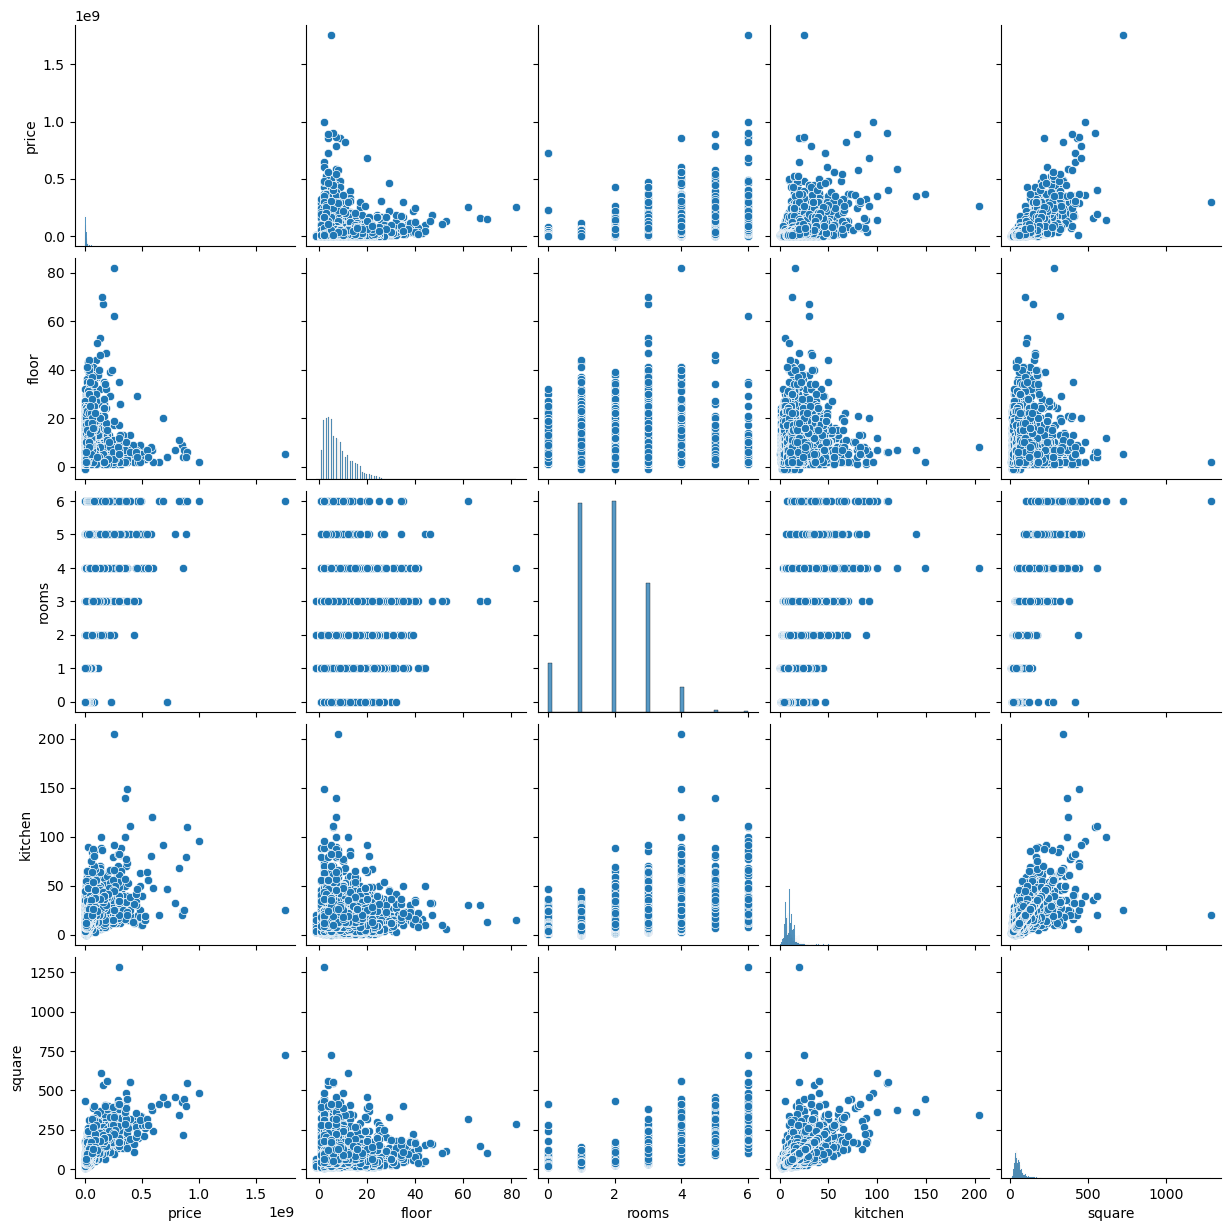

In [27]:
sns.pairplot(df)

In [28]:
count_rooms = df['rooms'].value_counts()
count_rooms

rooms
2    14391
1    14261
3     8787
0     3332
4     1709
5      129
6       79
Name: count, dtype: int64

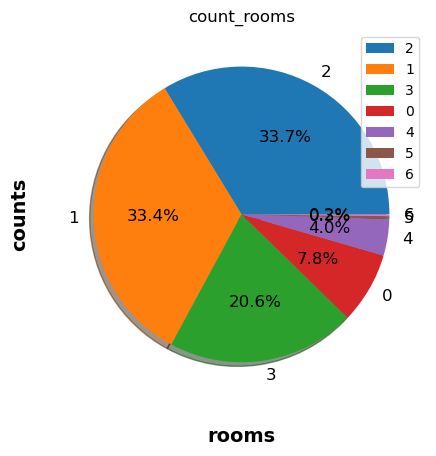

In [29]:
plt.figure()
explode = (0,0.09)
count_rooms.plot(kind = 'pie', fontsize = 12, autopct = '%.1f%%',shadow = True)
plt.title('count_rooms')
plt.xlabel('rooms', weight = "bold", color = "#000000", fontsize = 14, labelpad = 20)
plt.ylabel('counts', weight = "bold", color = "#000000", fontsize = 14, labelpad = 20)
plt.legend(labels = count_rooms.index, loc = "best")
plt.show()

In [30]:
count_view = df['view'].value_counts()
count_view

view
garden    22571
street    14614
park       2550
water      1504
forest     1449
Name: count, dtype: int64

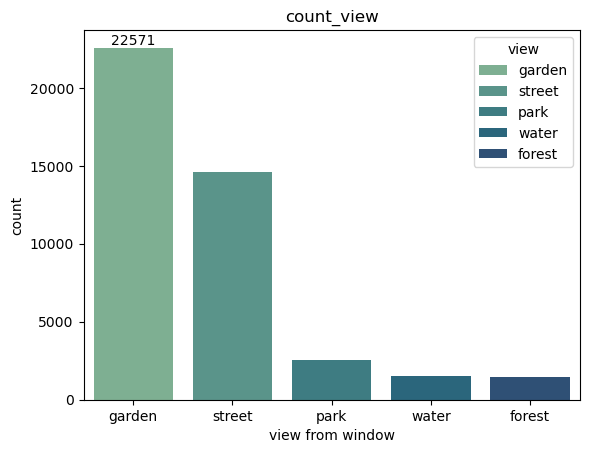

In [31]:
plt.figure()
ax = sns.barplot(x=count_view.index, y=count_view.values, palette='crest', legend=True, hue=count_view.index)
ax.bar_label(ax.containers[0], fontsize=10)
plt.title('count_view')
plt.xlabel('view from window')
plt.ylabel('count')
plt.show()

In [32]:
count_city = df['city'].value_counts()
count_city

city
Санкт-Петербург    12741
Москва             11041
Сочи                4172
Краснодар           4035
Новосибирск         3140
Балашиха            2077
Екатеринбург        1444
Геленджик           1223
Нижний Новгород      973
Анапа                933
Самара               462
Казань               447
Name: count, dtype: int64

In [33]:
count_type_perec = df['type_perec'].value_counts()
count_type_perec

type_perec
Монолитный             39050
Кирпичный               1375
Панельный               1007
Монолитно-кирпичный      689
Деревянный               283
Блочный                  246
Старый фонд               30
Сталинский                 8
Name: count, dtype: int64

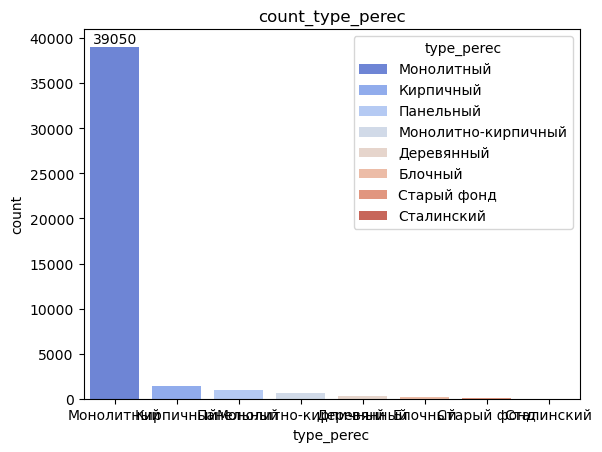

In [34]:
plt.figure()
ax = sns.barplot(x = count_type_perec.index,y = count_type_perec.values, palette='coolwarm', legend=True, hue=count_type_perec.index)
ax.bar_label(ax.containers[0], fontsize=10);
plt.title('count_type_perec')
plt.xlabel('type_perec')
plt.ylabel('count')
plt.show()

In [35]:
count_hot_water = df['hot_water'].value_counts()
count_hot_water

hot_water
Центральное                                              40967
Поквартирный котел                                         681
Закрытая с приготовлением горячей воды на ЦТП              668
Газовая колонка                                            150
Закрытая с приготовлением горячей воды на ИТП              136
Автономная котельная (крышная встроенно-пристроенная)       86
Name: count, dtype: int64

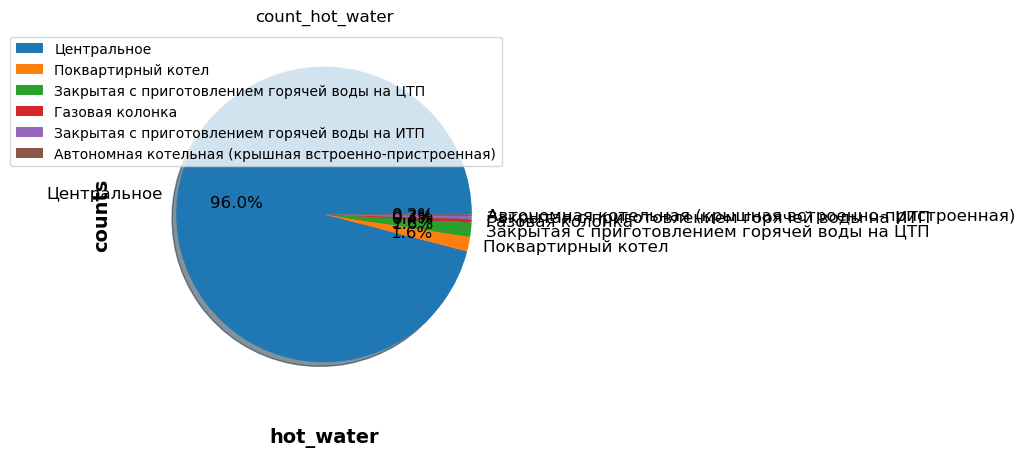

In [36]:
plt.figure()
explode = (0,0.09)
count_hot_water.plot(kind = 'pie', fontsize = 12, autopct = '%.1f%%',shadow = True)
plt.title('count_hot_water')
plt.xlabel('hot_water', weight = "bold", color = "#000000", fontsize = 14, labelpad = 20)
plt.ylabel('counts', weight = "bold", color = "#000000", fontsize = 14, labelpad = 20)
plt.legend(labels = count_hot_water.index, loc = "best")
plt.show()

In [37]:
count_remont = df['remont'].value_counts()
count_remont

remont
well_done         15148
standard          13474
design             7837
without_repair     6176
simple               53
Name: count, dtype: int64

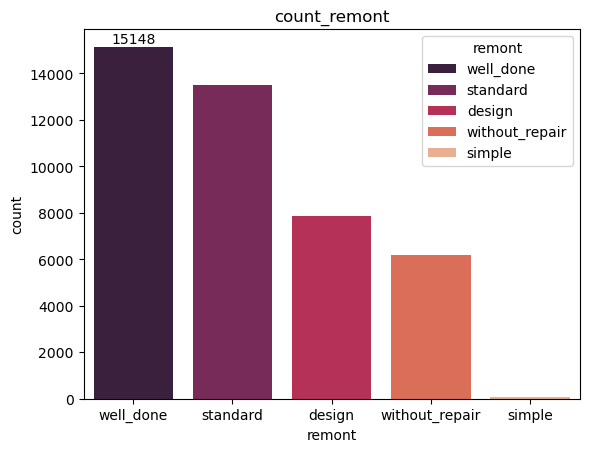

In [38]:
plt.figure()
ax = sns.barplot(x=count_remont.index,y=count_remont.values, palette='rocket', legend=True, hue=count_remont.index)
ax.bar_label(ax.containers[0], fontsize=10);
plt.title('count_remont')
plt.xlabel('remont')
plt.ylabel('count')
plt.show()

In [39]:
df.city.unique()

array(['Анапа', 'Балашиха', 'Екатеринбург', 'Геленджик', 'Казань',
       'Краснодар', 'Москва', 'Нижний Новгород', 'Новосибирск', 'Самара',
       'Сочи', 'Санкт-Петербург'], dtype=object)

# Encoding Data :bomb:

In [ ]:
le = OneHotEncoder()
encoder = le.fit_transform(df[["city", 'remont', 'view', 'type_perec', 'hot_water', 'balcon']])
encoder

In [ ]:
plt.figure()
sns.heatmap(df.corr(), cmap='crest', annot=True, fmt=".2f", linewidths=0.5, cbar=True)
plt.show()

In [ ]:
df.info()

# :star: Features & Target :dart: 

In [ ]:
x = df.drop(columns=['price'])
y = df['price']

In [ ]:
y

In [ ]:
y=y.values.reshape(-1,1)
y

# :mag: Scaling and split :scissors:

In [ ]:
# scaler_x = MinMaxScaler()
# scaler_y = MinMaxScaler()
# x = scaler_x.fit_transform(x)
# y = scaler_y.fit_transform(y)

X_train,X_test,y_train,y_test=train_test_split(x, y, test_size=0.2, shuffle=True, random_state=42)
# joblib.dump(scaler_x, "../../scalers/alpha1_x.bin")
# joblib.dump(scaler_y, "../../scalers/alpha1_y.bin")

In [ ]:
x.info()

# Teach Models :books:

In [ ]:
model = CatBoostRegressor(cat_features=[3, 6, 7, 8, 9, 10], iterations=10000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
    
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
    
print(f"Results for CatBoost:")
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared Score:", r2)
print()

# Save the best model :floppy_disk:

In [ ]:
# name = Name[accuracy.index(max(accuracy))]
# model = models[Name[accuracy.index(max(accuracy))]]
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
    
# mse = mean_squared_error(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)
# rmse = root_mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)
    
# print(f"Results for {name}:")
# print("Mean Squared Error (MSE):", mse)
# print("Root Mean Squared Error (RMSE):", rmse)
# print("Mean Absolute Error (MAE):", mae)
# print("R-squared Score:", r2)

model.save_model("../../models/alpha1.bin")


In [ ]:
model.feature_importances_

# Test the best model :triangular_ruler:

# Import test dataset :scroll:

In [ ]:
x_plus = pd.read_csv("../../src/predict_test.csv")

In [ ]:
x_plus

In [ ]:
columns = ["city", "remont", "view", "type_perec", "hot_water", "fundament", "year"]
for column in columns:
    x_plus[column]=le.fit_transform(x_plus[column])
    
x_plus = scaler_x.fit_transform(x_plus)

In [ ]:
y_pred_plus = model.predict(x_plus)
y_pred_plus

In [ ]:
[y_pred_plus]

In [ ]:
y_pred_plus = scaler_y.inverse_transform([y_pred_plus])
ceil(y_pred_plus[0][0])